# Skip to the end if you want to see summary and final interpretations.

In [1]:
import time
import requests
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
# Cell 1: Import libraries and define timestamp function



def get_correct_timestamps():
    """
    Returns start and end timestamps (in seconds) for the last 24 hours.
    """
    now = datetime.utcnow()
    start_time = int((now - timedelta(hours=24)).timestamp())
    end_time = int(now.timestamp())
    return start_time, end_time

# Test the timestamp function
start_time, end_time = get_correct_timestamps()
print("Start Time (sec):", start_time)
print("End Time (sec):", end_time)


Start Time (sec): 1741564266
End Time (sec): 1741650666


C:\Users\kshri\AppData\Local\Temp\ipykernel_18244\917152293.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


In [3]:
# Cell 2: Fetch trace metadata (IDs) from Tempo using a >1.5s duration filter

def fetch_tempo_traces(base_url, username, password, duration_threshold_ms=1500, limit=1000):
    """
    Fetch trace metadata for traces with at least one span exceeding the duration threshold.
    """
    start_time, end_time = get_correct_timestamps()
    params = {
        "query": f'{{span.duration > {duration_threshold_ms}ms}}',  # Filter for >1500ms
        "start": start_time,
        "end": end_time,
        "limit": limit
    }
    
    url = f"{base_url}/api/search"
    print("Fetching traces with parameters:", params)
    
    response = requests.get(url, params=params, auth=(username, password))
    response.raise_for_status()
    data = response.json()
    
    traces = data.get("traces", [])
    df = pd.DataFrame(traces)
    print(f"Fetched {len(df)} traces.")
    return df

# Set your Tempo credentials and base URL
base_url = "https://tempo.aarthy.medblocks.com"
username = "medblocks"
password = "medblocksObsAuth22"

# Fetch the trace metadata
traces_df = fetch_tempo_traces(base_url, username, password)
traces_df.head()


C:\Users\kshri\AppData\Local\Temp\ipykernel_18244\917152293.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


Fetching traces with parameters: {'query': '{span.duration > 1500ms}', 'start': 1741564270, 'end': 1741650670, 'limit': 1000}
Fetched 1000 traces.


,traceID,rootServiceName,rootTraceName,startTimeUnixNano,durationMs
0,9fb48011dd38f0b6362baee45e9d876,ignite,GET,1741589021773000000,74.0
1,4f4d340c926ec6ee5d1d05004710c51,ignite,POST,1741589021718000000,2001.0
2,191e2e9b527aa3714024b41458f25c9,ignite,/ehrbase getComposition receive,1741589008580000000,2.0
3,35fe3f9690edbcf3b0beca922931ee,ignite,GET,1741589004337000000,101.0
4,7d226e779f7e7bb38f5ec8d2453f6ca,ignite,GET,1741588997895000000,97.0


In [4]:
traces_df.shape

(1000, 5)

In [5]:
# Cell 3: Updated recursive extraction function that calculates duration if needed

def fetch_trace_details(base_url, trace_id, username, password):
    """
    Fetch full trace details for a given trace ID.
    """
    url = f"{base_url}/api/traces/{trace_id}"
    response = requests.get(url, auth=(username, password))
    response.raise_for_status()
    return response.json()

def find_spans_recursive(obj):
    """
    Recursively searches the JSON object for dictionaries that appear to be spans.
    A span is identified if it contains 'spanID' or 'spanId'.
    """
    spans = []
    if isinstance(obj, dict):
        if "spanID" in obj or "spanId" in obj:
            spans.append(obj)
        else:
            for value in obj.values():
                spans.extend(find_spans_recursive(value))
    elif isinstance(obj, list):
        for item in obj:
            spans.extend(find_spans_recursive(item))
    return spans

# Updated extraction function using "startTimeUnixNano" and "endTimeUnixNano"

def extract_span_data_recursive(trace_json, fallback_trace_id=None):
    """
    Extracts span data from a trace JSON using a recursive search.
    Returns a list of dictionaries containing:
      - trace_id, span_id, service, url, db_statement, and duration_ms.
    If the 'duration' field is zero, attempts to calculate it from 
    'startTimeUnixNano' and 'endTimeUnixNano'.
    """
    spans = find_spans_recursive(trace_json)
    records = []
    for span in spans:
        span_id = span.get("spanID") or span.get("spanId")
        
        # Attempt to get the provided duration
        try:
            duration_ns = int(span.get("duration", "0"))
        except Exception:
            duration_ns = 0
        
        # If duration is zero, try calculating using UnixNano fields
        if duration_ns == 0:
            try:
                start_ns = int(span.get("startTimeUnixNano", "0"))
                end_ns = int(span.get("endTimeUnixNano", "0"))
                if start_ns and end_ns and end_ns > start_ns:
                    duration_ns = end_ns - start_ns
            except Exception:
                duration_ns = 0
                
        duration_ms = duration_ns / 1e6  # Convert nanoseconds to milliseconds
        
        url_attr = None
        db_statement = None
        service = None
        
        # Extract common attributes from the span
        for attr in span.get("attributes", []):
            key = attr.get("key")
            if key == "http.target":
                url_attr = attr.get("value", {}).get("stringValue")
            elif key == "db.statement":
                db_statement = attr.get("value", {}).get("stringValue")
            elif key == "service.name":
                service = attr.get("value", {}).get("stringValue")
                
        trace_id = trace_json.get("traceID") or fallback_trace_id
        records.append({
            "trace_id": trace_id,
            "span_id": span_id,
            "service": service,
            "url": url_attr,
            "db_statement": db_statement,
            "duration_ms": duration_ms
        })
    return records

# Test the updated function on one trace
if not traces_df.empty:
    sample_trace_id = traces_df['traceID'].iloc[0]
    trace_json = fetch_trace_details(base_url, sample_trace_id, username, password)
    span_records = extract_span_data_recursive(trace_json, fallback_trace_id=sample_trace_id)
    spans_df = pd.DataFrame(span_records)
    print("Extracted span data for one trace:")
    print(spans_df.head())
else:
    print("No trace IDs available for extraction test.")



Extracted span data for one trace:
                          trace_id       span_id service  \
0  9fb48011dd38f0b6362baee45e9d876  dsKb9FKO6qs=    None   
1  9fb48011dd38f0b6362baee45e9d876  /Q2KmXH+pug=    None   
2  9fb48011dd38f0b6362baee45e9d876  SVXc3/jyv+g=    None   
3  9fb48011dd38f0b6362baee45e9d876  mIaH65G/0Co=    None   

                                                 url db_statement  duration_ms  
0                                               None         None     6.108985  
1                                               None         None     7.411116  
2                                        /v1/graphql         None    31.220091  
3  /api/forms?form=3&ehrId=2bad7f73-cc0a-5af0-927...         None    74.589039  


In [6]:
# Cell 4: Combine span data from all traces

all_spans = []
for trace_id in traces_df.get('traceID', []):
    try:
        trace_json = fetch_trace_details(base_url, trace_id, username, password)
        span_records = extract_span_data_recursive(trace_json, fallback_trace_id=trace_id)
        all_spans.extend(span_records)
    except Exception as e:
        print(f"Error processing trace {trace_id}: {e}")

all_spans_df = pd.DataFrame(all_spans)
print("Combined span data from all traces:")
print(all_spans_df.head())


Combined span data from all traces:
                          trace_id       span_id service  \
0  9fb48011dd38f0b6362baee45e9d876  dsKb9FKO6qs=    None   
1  9fb48011dd38f0b6362baee45e9d876  /Q2KmXH+pug=    None   
2  9fb48011dd38f0b6362baee45e9d876  SVXc3/jyv+g=    None   
3  9fb48011dd38f0b6362baee45e9d876  mIaH65G/0Co=    None   
4  4f4d340c926ec6ee5d1d05004710c51  fYGU/qgy5EY=    None   

                                                 url db_statement  duration_ms  
0                                               None         None     6.108985  
1                                               None         None     7.411116  
2                                        /v1/graphql         None    31.220091  
3  /api/forms?form=3&ehrId=2bad7f73-cc0a-5af0-927...         None    74.589039  
4                                               None         None     7.800830  


Top 10 URLs & Services by Total Duration:
Empty DataFrame
Columns: [url, service, duration_ms]
Index: []


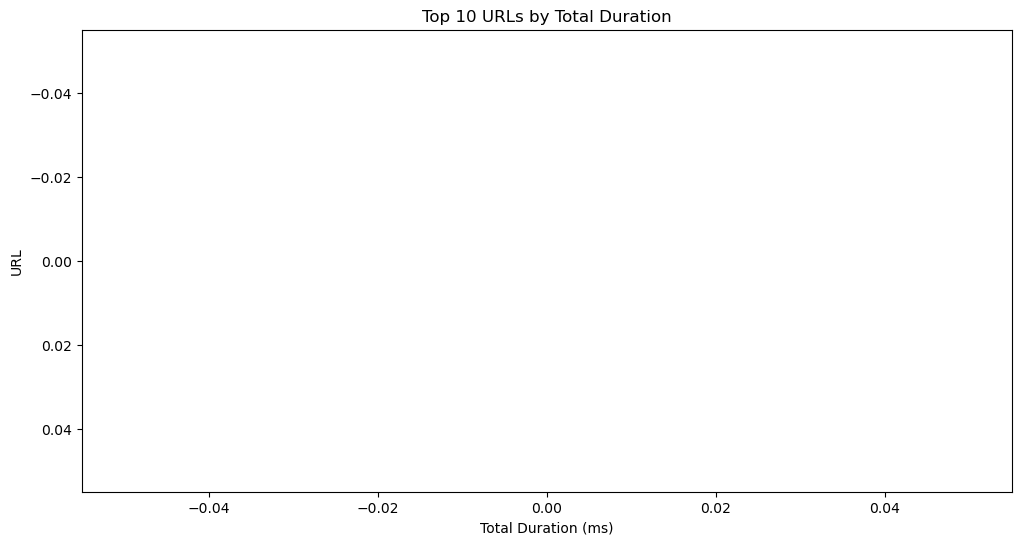

Top 10 URLs by Average Duration:
                                                   url  duration_ms
210                 /api/search?searchString=AHA110181  2175.124011
209                     /api/search?searchString=AHA06  2123.672366
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...  2099.735655
211                 /api/search?searchString=AHA175043  1842.724002
453  /patient/35370bda-adc1-5966-96b9-e68fcfb694eb/...  1742.695746
456  /patient/b09005be-6ed0-4705-883c-c61a5b1ab402/...  1630.048275
452  /patient/2f936b8c-9aa3-5615-99f0-193879100916/...  1047.443611
360                                       /api/widgets  1004.522621
316  /api/userform?patient=0bce6d18-11fe-53f2-a844-...   905.609240
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...   888.192857


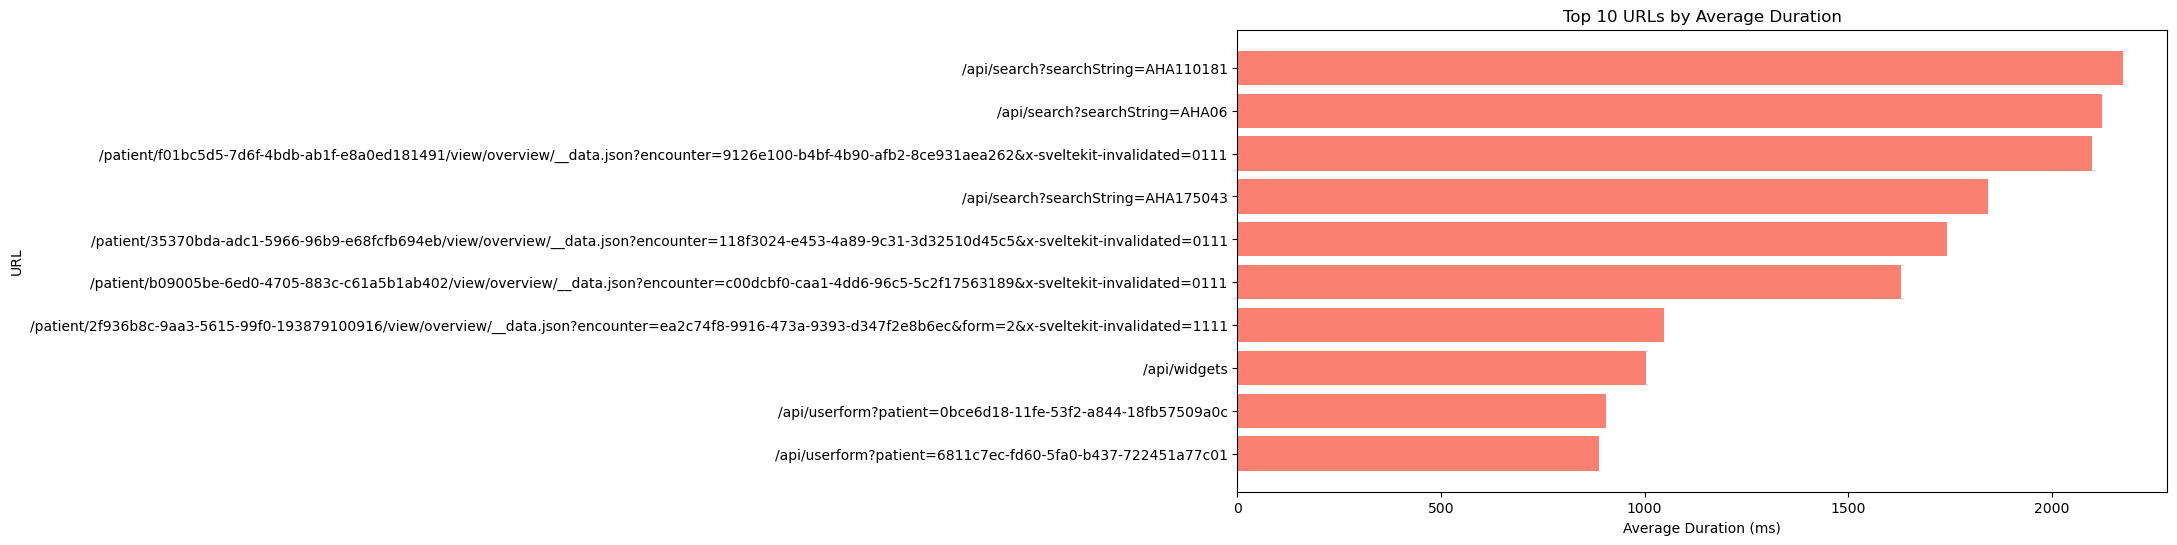

Top 10 Slowest SQL Queries by Average Duration:
                                          db_statement  duration_ms
105  select "content" from "patient" where exists (...  1004.706763
104  select "content" from "patient" where exists (...  1004.520468
141  select count(*) as "total" from "encounter" wh...   313.515637
140  select count(*) as "total" from "encounter" wh...   313.330477
107  select "content" from "patient" where tsv_text...   126.321496
106  select "content" from "patient" where tsv_text...   126.135316
173  select count(*) as "total" from "encounter" wh...    27.716584
157  select count(*) as "total" from "encounter" wh...    27.286082
84   select "content" from "patient" where "id" = ?...    20.963791
82   select "content" from "patient" where "id" = $...    20.762672


ValueError: 
select "content" from "patient" where exists (select 1 from jsonb_to_recordset(fhir.patient.telecom) AS telecom_record(system text, value text, use text) where regexp_replace(telecom_record.value, '\D', '', 'g') ILIKE $1) order by "id" asc, "updated_at" desc limit $2
                                                                                                                                                                                                                          ^
ParseException: Expected end of text, found '$'  (at char 218), (line:1, col:219)

<Figure size 1200x600 with 1 Axes>

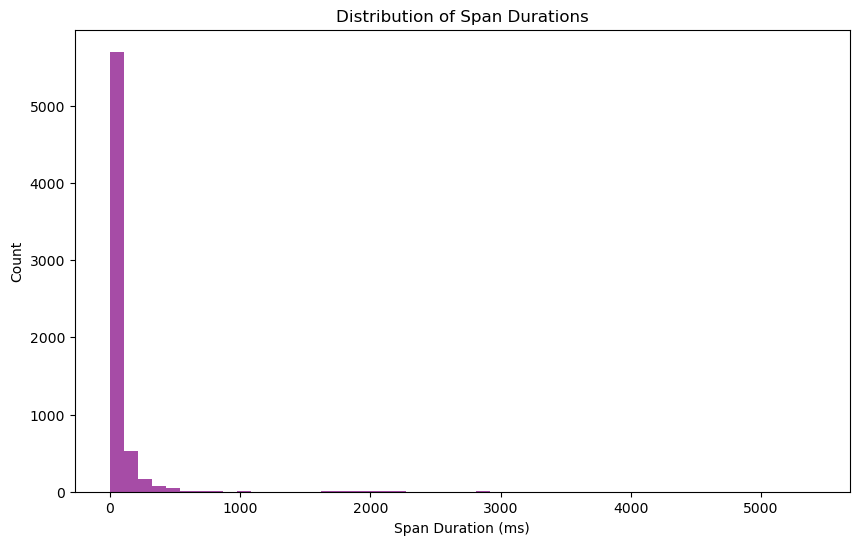

No spans with service information found.


In [7]:
# Cell 5: Data Analysis and Visualization

# Filter for spans with non-zero duration
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

if df_nonzero.empty:
    print("No spans with non-zero duration found. You may need to collect more data.")
else:
    # A. Top URLs & Services by Total Duration
    url_service_agg = df_nonzero.groupby(['url', 'service'])['duration_ms'].sum().reset_index()
    top_url_service = url_service_agg.sort_values(by='duration_ms', ascending=False).head(10)
    print("Top 10 URLs & Services by Total Duration:")
    print(top_url_service)
    
    plt.figure(figsize=(12,6))
    plt.barh(top_url_service['url'], top_url_service['duration_ms'], color='skyblue')
    plt.xlabel("Total Duration (ms)")
    plt.ylabel("URL")
    plt.title("Top 10 URLs by Total Duration")
    plt.gca().invert_yaxis()  # Highest durations on top
    plt.show()
    
    # B. Average Request Time per URL
    url_avg = df_nonzero.groupby('url')['duration_ms'].mean().reset_index()
    top_url_avg = url_avg.sort_values(by='duration_ms', ascending=False).head(10)
    print("Top 10 URLs by Average Duration:")
    print(top_url_avg)
    
    plt.figure(figsize=(12,6))
    plt.barh(top_url_avg['url'], top_url_avg['duration_ms'], color='salmon')
    plt.xlabel("Average Duration (ms)")
    plt.ylabel("URL")
    plt.title("Top 10 URLs by Average Duration")
    plt.gca().invert_yaxis()
    plt.show()
    
    # C. Slowest SQL Queries (if available)
    sql_df = df_nonzero[df_nonzero['db_statement'].notnull()]
    if sql_df.empty:
        print("No SQL queries found in the data.")
    else:
        sql_avg = sql_df.groupby('db_statement')['duration_ms'].mean().reset_index()
        top_sql_avg = sql_avg.sort_values(by='duration_ms', ascending=False).head(10)
        print("Top 10 Slowest SQL Queries by Average Duration:")
        print(top_sql_avg)
        
        plt.figure(figsize=(12,6))
        plt.barh(top_sql_avg['db_statement'], top_sql_avg['duration_ms'], color='lightgreen')
        plt.xlabel("Average Duration (ms)")
        plt.ylabel("SQL Query")
        plt.title("Top 10 Slowest SQL Queries")
        plt.gca().invert_yaxis()
        plt.show()
    
    # D. Additional Analysis: Histogram of Span Durations
    plt.figure(figsize=(10,6))
    plt.hist(df_nonzero['duration_ms'], bins=50, color='purple', alpha=0.7)
    plt.xlabel("Span Duration (ms)")
    plt.ylabel("Count")
    plt.title("Distribution of Span Durations")
    plt.show()
    
    # E. Top Services by Total Duration
    service_df = df_nonzero[df_nonzero['service'].notnull()]
    if service_df.empty:
        print("No spans with service information found.")
    else:
        service_agg = service_df.groupby('service')['duration_ms'].sum().reset_index()
        top_services = service_agg.sort_values(by='duration_ms', ascending=False).head(10)
        print("Top 10 Services by Total Duration:")
        print(top_services)
        
        plt.figure(figsize=(12,6))
        plt.barh(top_services['service'], top_services['duration_ms'], color='orange')
        plt.xlabel("Total Duration (ms)")
        plt.ylabel("Service")
        plt.title("Top 10 Services by Total Duration")
        plt.gca().invert_yaxis()
        plt.show()


In [8]:
# Print the shape and columns of df_nonzero
print("df_nonzero shape:", df_nonzero.shape)
print("df_nonzero columns:", df_nonzero.columns)

# See how many unique services exist
print("Unique service values:", df_nonzero['service'].unique())

# Preview a few rows
df_nonzero.head(10)


df_nonzero shape: (6617, 6)
df_nonzero columns: Index(['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms'], dtype='object')
Unique service values: [None]


,trace_id,span_id,service,url,db_statement,duration_ms
0,9fb48011dd38f0b6362baee45e9d876,dsKb9FKO6qs=,None,None,None,6.108985
1,9fb48011dd38f0b6362baee45e9d876,/Q2KmXH+pug=,None,None,None,7.411116
2,9fb48011dd38f0b6362baee45e9d876,SVXc3/jyv+g=,None,/v1/graphql,None,31.220091
3,9fb48011dd38f0b6362baee45e9d876,mIaH65G/0Co=,None,/api/forms?form=3&ehrId=2bad7f73-cc0a-5af0-927...,None,74.589039
4,4f4d340c926ec6ee5d1d05004710c51,fYGU/qgy5EY=,None,None,None,7.800830
5,4f4d340c926ec6ee5d1d05004710c51,9HBzdvbBQZo=,None,None,None,37.727513
6,4f4d340c926ec6ee5d1d05004710c51,gKJWws/SuJY=,None,/ehrbase/rest/openehr/v1/query/aql,None,1994.159112
7,4f4d340c926ec6ee5d1d05004710c51,XnboSfraSoc=,None,/api/widgets,None,2001.523367
8,191e2e9b527aa3714024b41458f25c9,OfHzu6t6L5M=,None,None,"select ""id"", ""encounter"", ""compositionId"", ""te...",1.259441
9,191e2e9b527aa3714024b41458f25c9,vyg1VFt0K6s=,None,None,"select ""id"", ""encounter"", ""compositionId"", ""te...",1.419734


In [9]:
# If df_nonzero is empty, let's see how many total spans we had before filtering
print("all_spans_df shape:", all_spans_df.shape)
print(all_spans_df['duration_ms'].describe())

# Count how many have duration_ms > 0
nonzero_count = (all_spans_df['duration_ms'] > 0).sum()
print(f"Number of spans with duration_ms > 0: {nonzero_count}")


all_spans_df shape: (6617, 6)
count    6617.000000
mean       73.317028
std       281.417641
min         0.116684
25%         3.356076
50%        10.760139
75%        49.000299
max      5411.486636
Name: duration_ms, dtype: float64
Number of spans with duration_ms > 0: 6617


                                                   url   duration_ms
412                 /ehrbase/rest/openehr/v1/query/aql  85002.680559
360                                       /api/widgets  78352.764431
481                                        /v1/graphql  60736.721343
413                                              /fhir  25844.401935
212                                      /api/template   6164.448877
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...   2664.578570
210                 /api/search?searchString=AHA110181   2175.124011
209                     /api/search?searchString=AHA06   2123.672366
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...   2099.735655
203                                       /api/patient   1875.504604


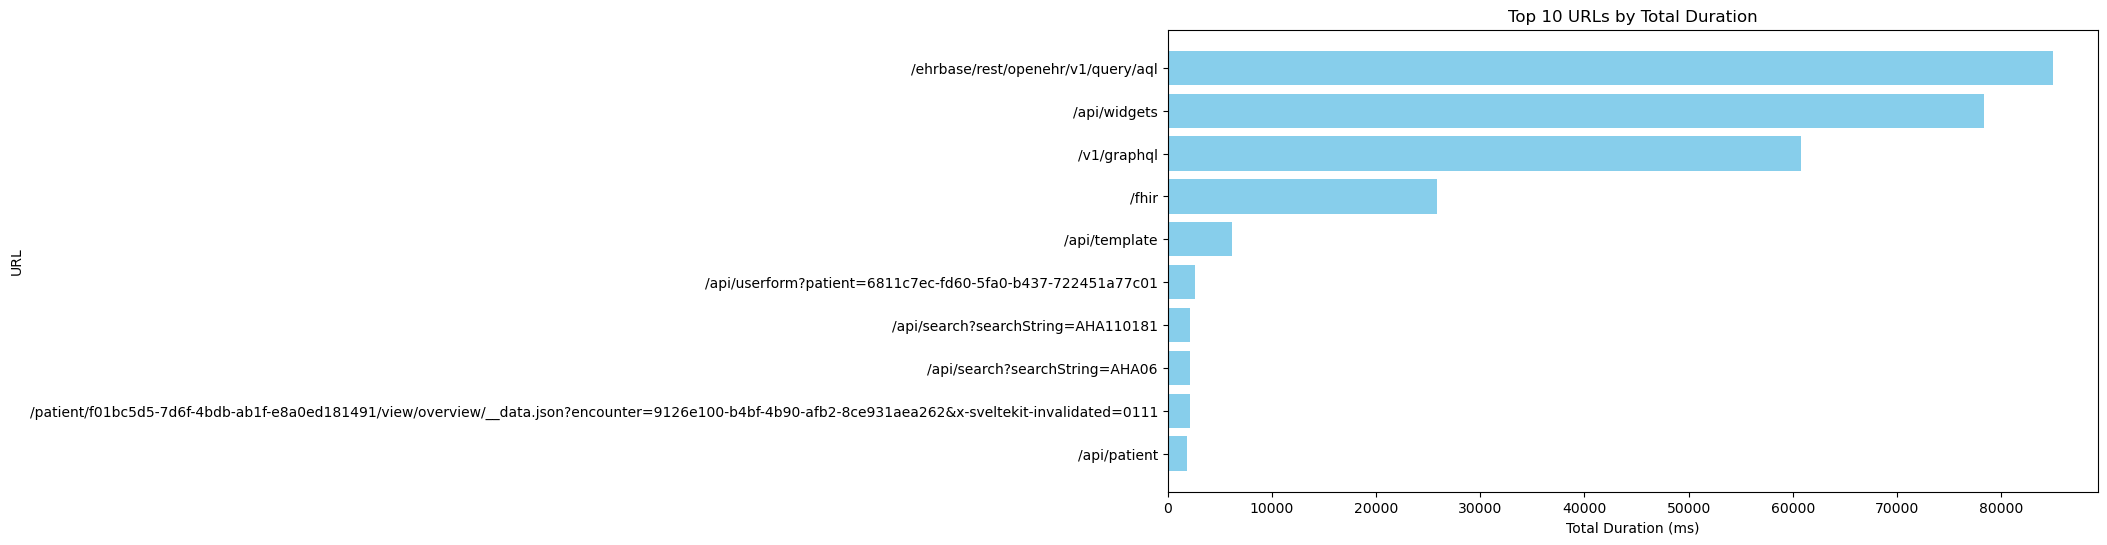

In [10]:
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print(top_url_agg)


plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration")
plt.gca().invert_yaxis()
plt.show()


df_nonzero shape: (6617, 6)
df_nonzero columns: Index(['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms'], dtype='object')
Unique service values: [None]

Top 10 URLs by Total Duration:
                                                   url   duration_ms
412                 /ehrbase/rest/openehr/v1/query/aql  85002.680559
360                                       /api/widgets  78352.764431
481                                        /v1/graphql  60736.721343
413                                              /fhir  25844.401935
212                                      /api/template   6164.448877
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...   2664.578570
210                 /api/search?searchString=AHA110181   2175.124011
209                     /api/search?searchString=AHA06   2123.672366
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...   2099.735655
203                                       /api/patient   1875.504604


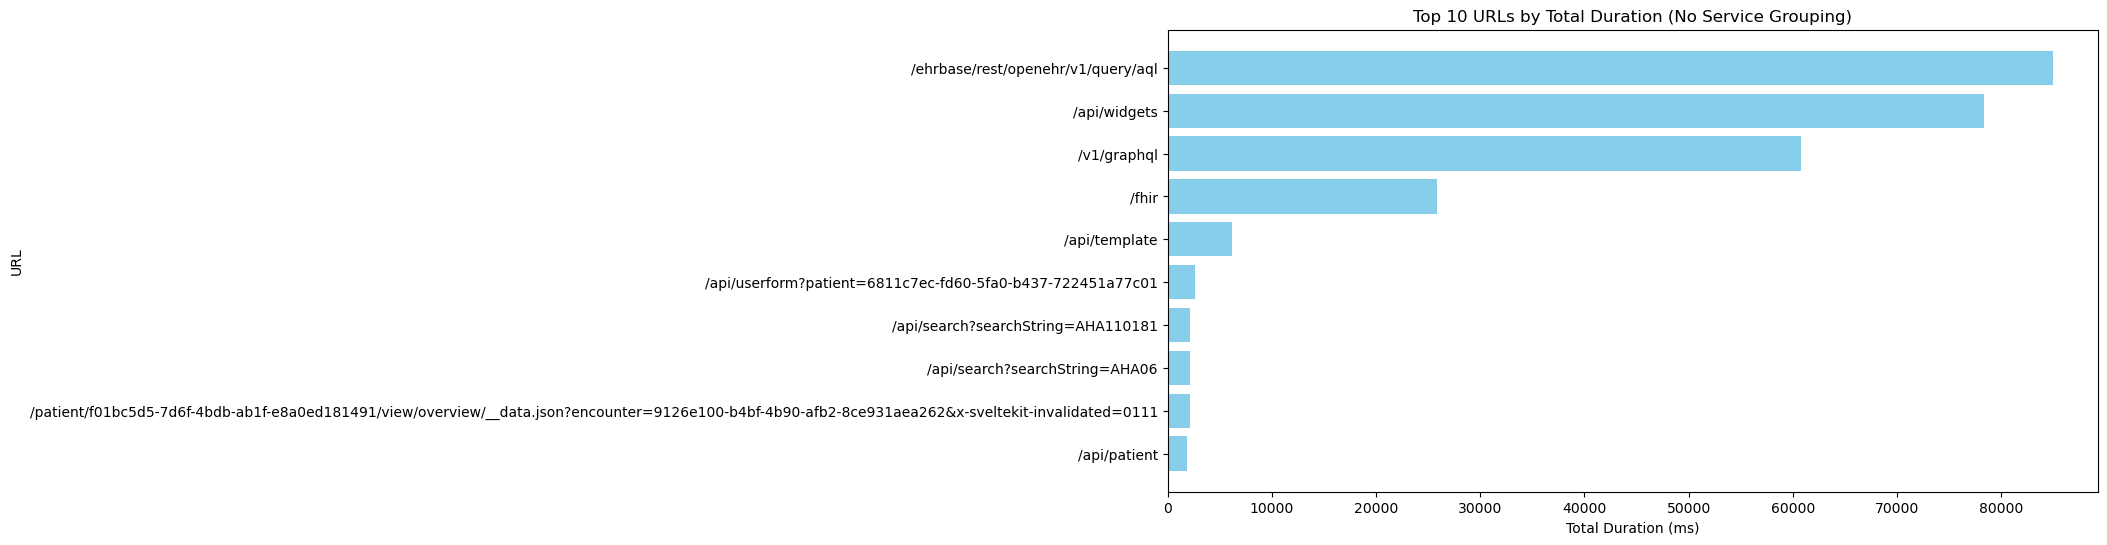


Top 10 URLs + Services by Total Duration:
                                                   url          service  \
412                 /ehrbase/rest/openehr/v1/query/aql  unknown-service   
360                                       /api/widgets  unknown-service   
481                                        /v1/graphql  unknown-service   
413                                              /fhir  unknown-service   
212                                      /api/template  unknown-service   
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...  unknown-service   
210                 /api/search?searchString=AHA110181  unknown-service   
209                     /api/search?searchString=AHA06  unknown-service   
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...  unknown-service   
203                                       /api/patient  unknown-service   

      duration_ms  
412  85002.680559  
360  78352.764431  
481  60736.721343  
413  25844.401935  
212   6164.448877  
331   2664.

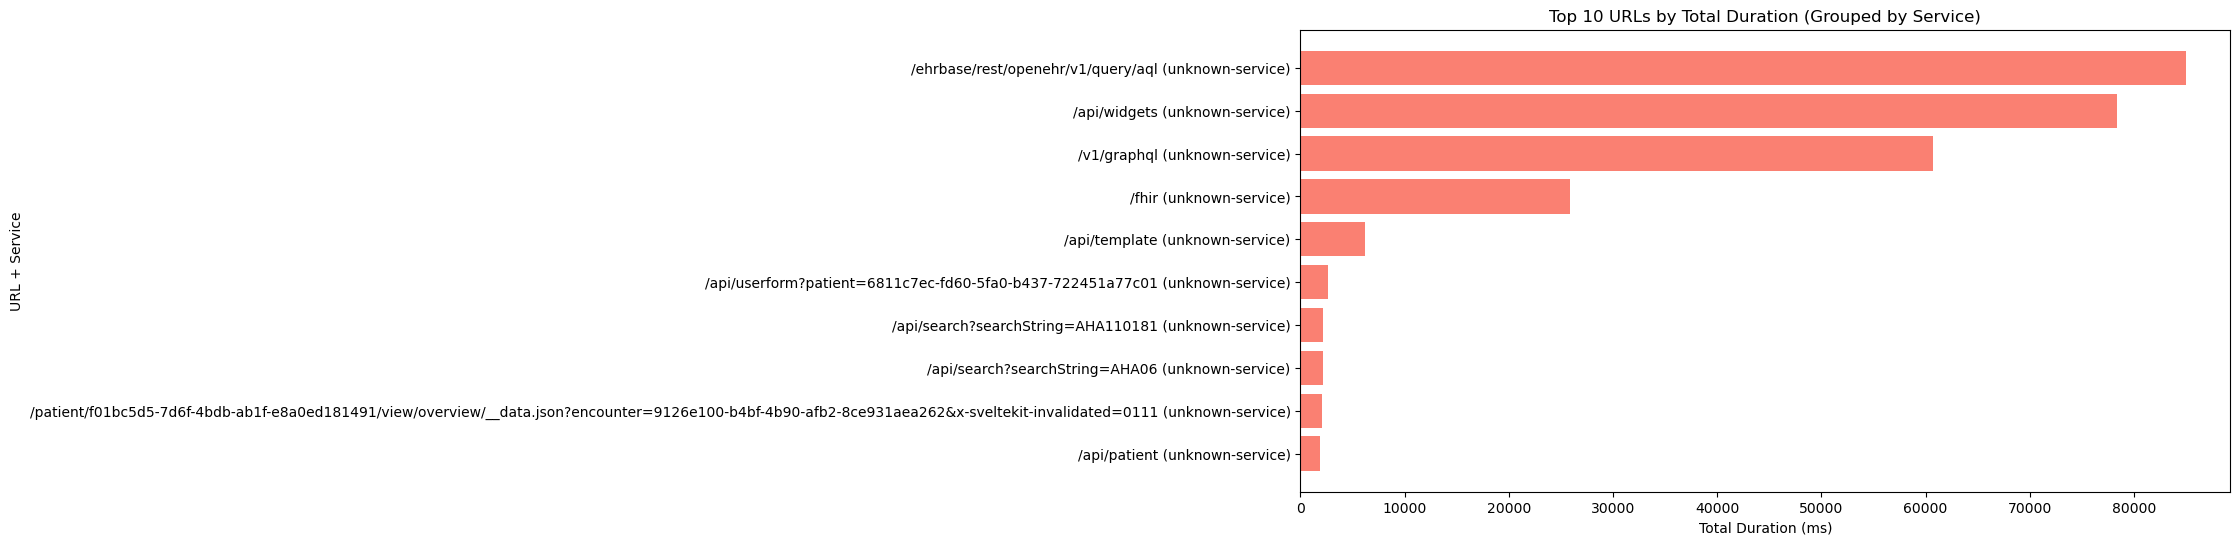

In [11]:
# Single-cell analysis and plotting



# 1. Basic DataFrame Info
print("df_nonzero shape:", df_nonzero.shape)
print("df_nonzero columns:", df_nonzero.columns)
print("Unique service values:", df_nonzero['service'].unique())

# 2. Top 10 URLs by Total Duration
url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print("\nTop 10 URLs by Total Duration:")
print(top_url_agg)

plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration (No Service Grouping)")
plt.gca().invert_yaxis()
plt.show()

# 3. Grouping by URL + Service (Filling missing service with a placeholder)
df_nonzero['service'] = df_nonzero['service'].fillna('unknown-service')
url_service_agg = df_nonzero.groupby(['url', 'service'])['duration_ms'].sum().reset_index()
top_url_service = url_service_agg.sort_values(by='duration_ms', ascending=False).head(10)

print("\nTop 10 URLs + Services by Total Duration:")
print(top_url_service)

# Create combined label: "URL (service)"
labels = top_url_service['url'] + " (" + top_url_service['service'] + ")"

plt.figure(figsize=(12,6))
plt.barh(labels, top_url_service['duration_ms'], color='salmon')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL + Service")
plt.title("Top 10 URLs by Total Duration (Grouped by Service)")
plt.gca().invert_yaxis()
plt.show()


# Issue:  spans never set a service name. 

# Potential Bottlenecks

/socket.io with ~25 s total duration might be a single outlier or multiple slow calls.

/ehrbase/rest/openehr/v1/query/aql and /api/widgets also have high total durations (7 seconds and 6.95 seconds, respectively).

In [13]:
# Group by URL, compute total duration, count, and average
stats_by_url = df_nonzero.groupby('url').agg(
    total_duration=('duration_ms', 'sum'),
    count=('duration_ms', 'count'),
    avg_duration=('duration_ms', 'mean')
).reset_index()

# Sort by total_duration descending
stats_by_url = stats_by_url.sort_values('total_duration', ascending=False)

print("Stats by URL (total, count, average duration):")
print(stats_by_url.head(10))


Stats by URL (total, count, average duration):
                                                   url  total_duration  count  \
412                 /ehrbase/rest/openehr/v1/query/aql    85002.680559    132   
360                                       /api/widgets    78352.764431     78   
481                                        /v1/graphql    60736.721343    849   
413                                              /fhir    25844.401935    128   
212                                      /api/template     6164.448877     70   
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...     2664.578570      3   
210                 /api/search?searchString=AHA110181     2175.124011      1   
209                     /api/search?searchString=AHA06     2123.672366      1   
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...     2099.735655      1   
203                                       /api/patient     1875.504604      4   

     avg_duration  
412    643.959701  
360   1004.522621  
4

In [14]:
socketio_df = df_nonzero[df_nonzero['url'].str.contains('/socket.io', na=False)]
print("Socket.IO spans:")
print(socketio_df.describe())

# Possibly look at the top 5 slowest calls
top_slowest_socketio = socketio_df.nlargest(5, 'duration_ms')
print("\nTop 5 slowest socket.io spans:")
print(top_slowest_socketio[['trace_id', 'span_id', 'duration_ms']])


Socket.IO spans:
       duration_ms
count    20.000000
mean     14.575081
std      41.393699
min       0.564345
25%       1.108295
50%       1.338067
75%       2.132273
max     182.174434

Top 5 slowest socket.io spans:
                             trace_id       span_id  duration_ms
3272  4c934792b10b97d2f645e0124b00441  qX2E+pFFOpY=   182.174434
5412  9557555ca41bb3a2eeeabdbd5fdaa62  /ZeH/15jUxo=    48.171494
5095  b6cd8bc6e19ecc8d22da96ed63834d4  VEukEwE9pr0=    35.193565
3099  46543a109b9acff584a8cab20dc70e2  pqvBjHIZNng=     5.166420
3325  a76ee2a6101aef22d07188c067d3094  DWJrmBJo/2Q=     2.554999


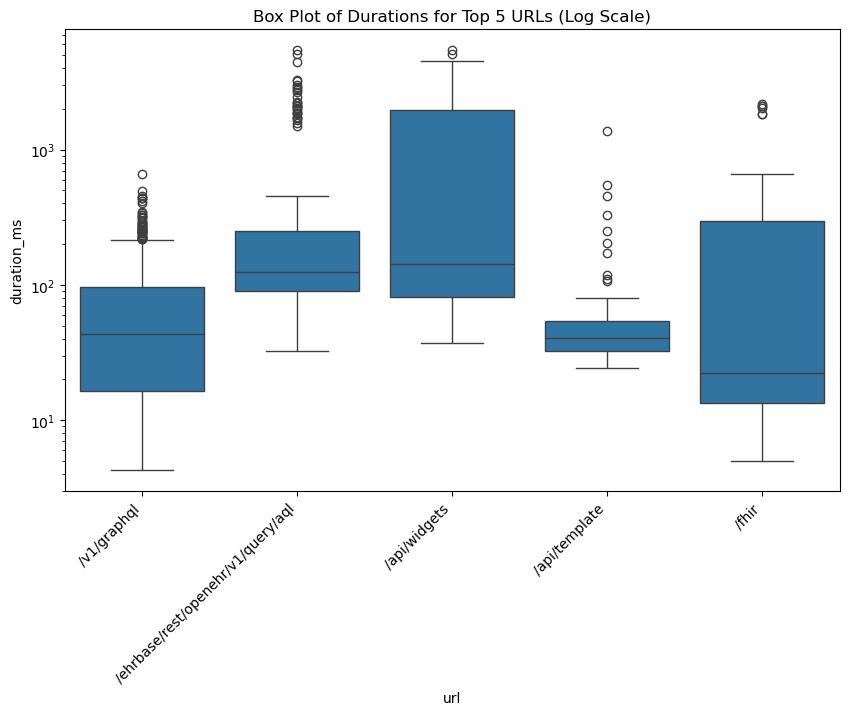

In [15]:

# Focus on top 5 URLs by total duration
top5_urls = stats_by_url.head(5)['url']
filtered_df = df_nonzero[df_nonzero['url'].isin(top5_urls)]

plt.figure(figsize=(10,6))
sns.boxplot(x='url', y='duration_ms', data=filtered_df)

# Apply a log scale on the y-axis
plt.yscale('log')

plt.xticks(rotation=45, ha='right')
plt.title("Box Plot of Durations for Top 5 URLs (Log Scale)")
plt.show()


/ehrbase/rest/openehr/v1/query/aql: 14 calls total ~7 s → ~500 ms each.
If 500 ms is normal for your queries, that might be acceptable—or it might be slow if you expect 100 ms.

/api/widgets: 12 calls total ~6.95 s → ~580 ms each. Similar question: is half a second acceptable for “widgets”?

In [16]:
aql_df = df_nonzero[df_nonzero['url'].str.contains('/ehrbase/rest/openehr/v1/query/aql', na=False)]
print(aql_df.describe())

widgets_df = df_nonzero[df_nonzero['url'] == '/api/widgets']
print(widgets_df.describe())


       duration_ms
count   132.000000
mean    643.959701
std    1094.010866
min      32.486979
25%      90.891466
50%     124.275885
75%     248.870957
max    5405.928647
       duration_ms
count    78.000000
mean   1004.522621
std    1314.384827
min      36.914398
25%      81.226740
50%     143.667149
75%    1948.311365
max    5411.486636


# SUMMARY


# Top 10 URLs by Total Duration

                                                   url   duration_ms
412                 /ehrbase/rest/openehr/v1/query/aql  85002.680559
360                                       /api/widgets  78352.764431
481                                        /v1/graphql  60736.721343
413                                              /fhir  25844.401935
212                                      /api/template   6164.448877
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...   2664.578570
210                 /api/search?searchString=AHA110181   2175.124011
209                     /api/search?searchString=AHA06   2123.672366
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...   2099.735655
203                                       /api/patient   1875.504604


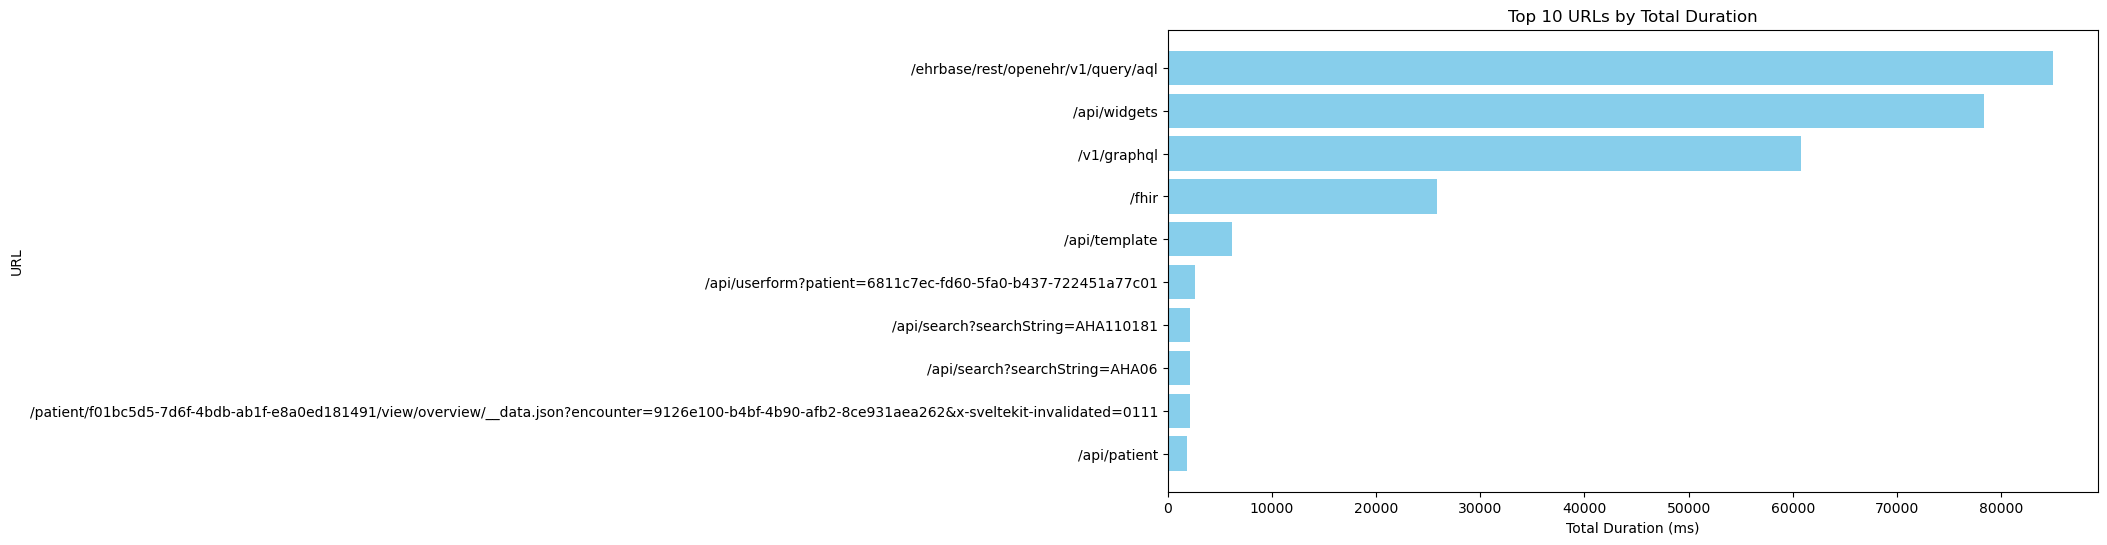

In [17]:
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print(top_url_agg)


plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration")
plt.gca().invert_yaxis()
plt.show()

C:\Users\kshri\AppData\Local\Temp\ipykernel_18244\891435505.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


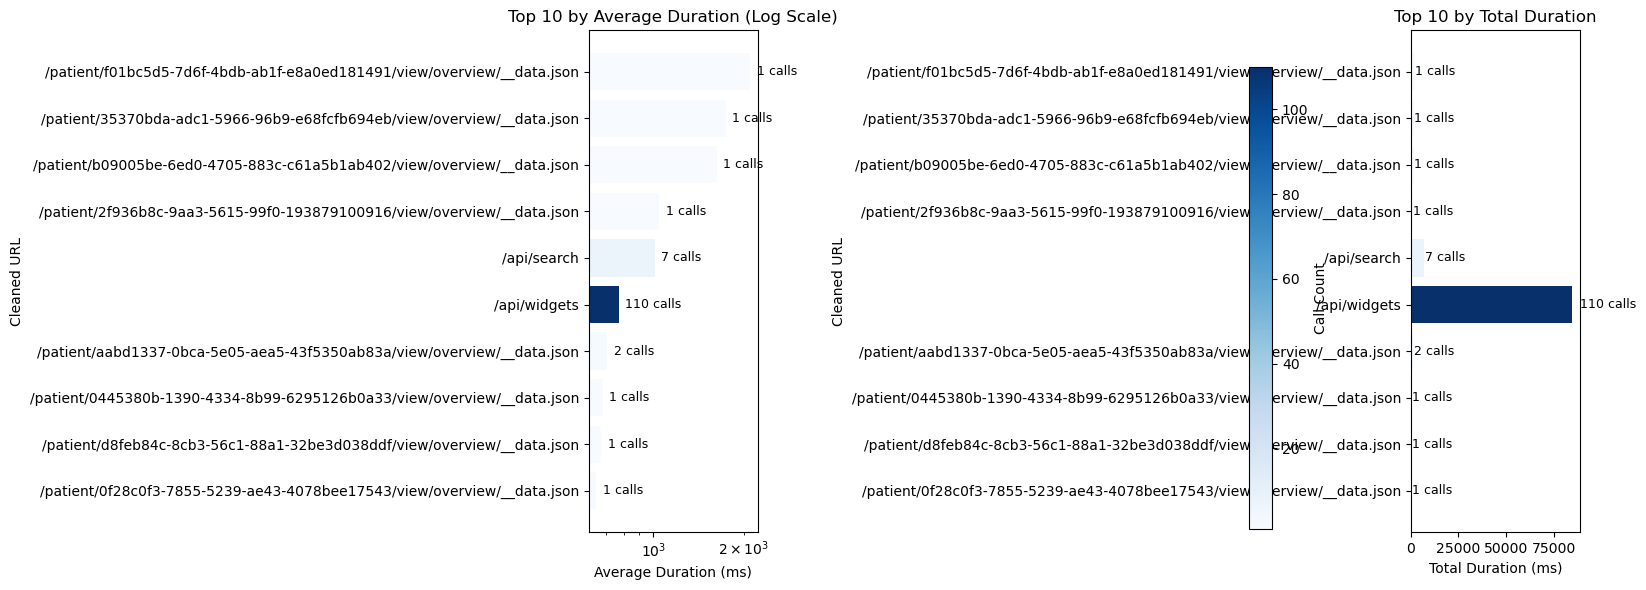

In [19]:


# -------------------------------------------------------------
#Create a helper function to strip query parameters
# -------------------------------------------------------------
def strip_query_params(url):
    if not isinstance(url, str):
        return url
    return url.split('?')[0]

# -------------------------------------------------------------
# Apply the cleaning logic to create a "clean_url" column
#    and aggregate stats by "clean_url"
# -------------------------------------------------------------
df_nonzero['clean_url'] = df_nonzero['url'].apply(strip_query_params)

stats_by_clean_url = df_nonzero.groupby('clean_url').agg(
    total_duration=('duration_ms', 'sum'),
    count=('duration_ms', 'count'),
    avg_duration=('duration_ms', 'mean')
).reset_index()

# Sort by average duration descending
stats_by_clean_url = stats_by_clean_url.sort_values('avg_duration', ascending=False)

# Pick top 10
top10 = stats_by_clean_url.head(10)

# -------------------------------------------------------------
# 3. Prepare color mapping based on call count
#  color each bar according to how many calls occurred.
# -------------------------------------------------------------
counts = top10['count'].values
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Blues
colors = [cmap(norm(c)) for c in counts]

# -------------------------------------------------------------
# 4. Create a figure with two subplots side-by-side
# -------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# -------------------------------------------------------------
# 4A. Left subplot: Average Duration (log scale)
# -------------------------------------------------------------
bars1 = ax1.barh(top10['clean_url'], top10['avg_duration'], color=colors)
ax1.set_xlabel("Average Duration (ms)")
ax1.set_ylabel("Cleaned URL")
ax1.set_title("Top 10 by Average Duration (Log Scale)")
ax1.invert_yaxis()  # largest bar on top
ax1.set_xscale('log')  # log scale to handle large outliers

# Label each bar with call count
for i, bar in enumerate(bars1):
    cnt = int(top10.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax1.text(label_x*1.05, label_y, f"{cnt} calls", va='center', fontsize=9)

# -------------------------------------------------------------
# 4B. Right subplot: Total Duration (linear scale)
# -------------------------------------------------------------
bars2 = ax2.barh(top10['clean_url'], top10['total_duration'], color=colors)
ax2.set_xlabel("Total Duration (ms)")
ax2.set_ylabel("Cleaned URL")
ax2.set_title("Top 10 by Total Duration")
ax2.invert_yaxis()  # largest bar on top

# Label each bar with call count
for i, bar in enumerate(bars2):
    cnt = int(top10.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax2.text(label_x*1.05, label_y, f"{cnt} calls", va='center', fontsize=9)

# -------------------------------------------------------------
# 5. Add a colorbar legend to indicate call count
# -------------------------------------------------------------
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for matplotlib < 3.2
cbar = fig.colorbar(sm, ax=[ax1, ax2], label='Call Count')

plt.tight_layout()
plt.show()


# Top 10 Slowest SQL Queries by Average Duration

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


def truncate_sql_end(sql, max_len=60):
    """
    Truncate the SQL statement to show the last `max_len` characters.
    If it's shorter than `max_len`, return the full statement.
    """
    sql_str = str(sql)
    if len(sql_str) <= max_len:
        return sql_str
    else:
        # '...' + last (max_len-3) characters
        return "..." + sql_str[-(max_len - 3):]

# 1) Create a truncated version of each query
stats_by_query['trunc_sql'] = stats_by_query['db_statement'].apply(truncate_sql_end)

# 2) Sort by average duration (descending) and pick top 10
stats_by_query = stats_by_query.sort_values('avg_duration', ascending=False).head(10)

# 3) Prepare color mapping based on call count
counts = stats_by_query['count'].values
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Reds
colors = [cmap(norm(c)) for c in counts]

# 4) Create a horizontal bar chart using truncated SQL
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(stats_by_query['trunc_sql'], stats_by_query['avg_duration'], color=colors)

ax.set_xlabel("Average Duration (ms)")
ax.set_ylabel("SQL Query (Truncated to Last Part)")
ax.set_title("Top 10 Slowest SQL Queries by Average Duration (Last-Part Trunc)")

# Flip the y-axis so the largest bar is on top
ax.invert_yaxis()

# 5) Label each bar with the call count
for i, bar in enumerate(bars):
    cnt = int(stats_by_query.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax.text(label_x * 1.02, label_y, f"{cnt} calls", va='center', fontsize=9)

# 6) Add a colorbar legend to indicate call count
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Call Count')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


NameError: name 'stats_by_query' is not defined

In [33]:
# work to be done to make this readable

# Box Plot of Durations for Top 5 URLs (Log Scale)

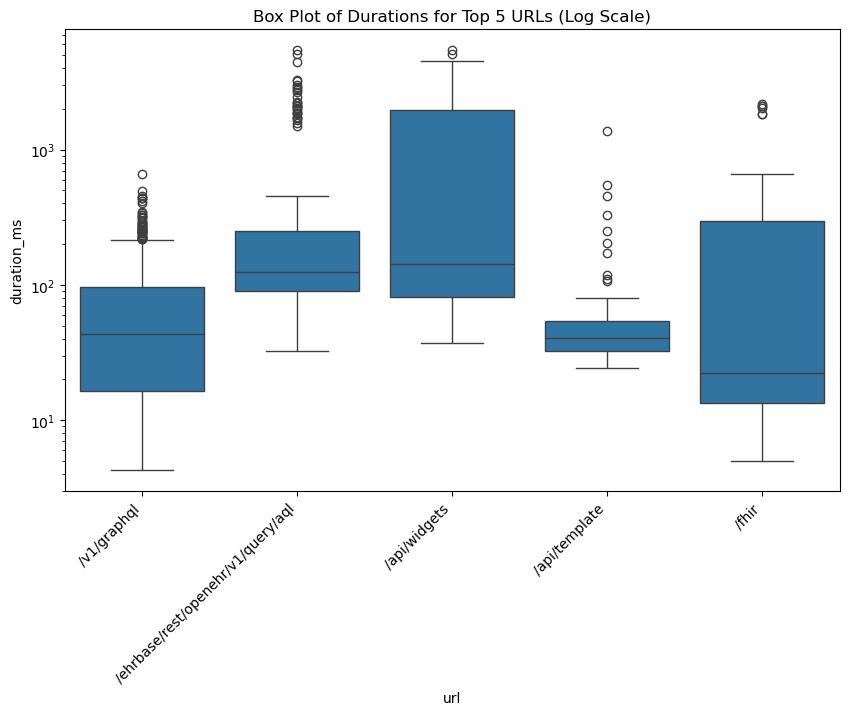

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focus on top 5 URLs by total duration
top5_urls = stats_by_url.head(5)['url']
filtered_df = df_nonzero[df_nonzero['url'].isin(top5_urls)]

plt.figure(figsize=(10,6))
sns.boxplot(x='url', y='duration_ms', data=filtered_df)

# Apply a log scale on the y-axis
plt.yscale('log')

plt.xticks(rotation=45, ha='right')
plt.title("Box Plot of Durations for Top 5 URLs (Log Scale)")
plt.show()

To interpret the box plot of durations for the top 5 URLs (log scale), follow these steps:

1. **Axes**:
    - The x-axis represents the duration of spans in milliseconds (ms).
    - The y-axis lists the top 5 URLs.

2. **Box Plot Components**:
    - **Box**: The central box represents the interquartile range (IQR), which contains the middle 50% of the data.
    - **Median Line**: The line inside the box indicates the median duration.
    - **Whiskers**: The lines extending from the box show the range of the data, excluding outliers.
    - **Outliers**: Points outside the whiskers are considered outliers and are plotted individually.

3. **Log Scale**:
    - The y-axis is on a logarithmic scale, which helps to visualize data with a wide range of values more effectively. This is particularly useful when there are large outliers.


Overall, the box plot helps identify URLs with high variability and potential performance issues, as well as those with more consistent performance. The log scale allows for better visualization of the differences in duration across URLs.

In [23]:
import pandas as pd

# Ensure all_spans_df has been defined earlier, with columns:
# ['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms']

# 1. Group spans by URL (ignoring rows with no URL) and calculate stats
agg_by_url = (
    all_spans_df[all_spans_df['url'].notnull()]
    .groupby('url')
    .agg(
        avg_duration=('duration_ms', 'mean'),
        call_count=('duration_ms', 'count'),
        max_duration=('duration_ms', 'max')
    )
    .reset_index()
)

# 2. Sort by average duration descending and pick the top 30
top30 = agg_by_url.sort_values('avg_duration', ascending=False).head(30)

print("Top 30 Network Calls by Average Duration:")
print(top30)

# 3. Get the list of URLs from the top 30
top30_urls = top30['url'].tolist()

# 4. Filter the original spans DataFrame for spans matching those URLs
top30_spans = all_spans_df[all_spans_df['url'].isin(top30_urls)]

print("\nSpan details for the Top 30 Slow Calls:")
print(top30_spans.sort_values(by='duration_ms', ascending=False))


Top 30 Network Calls by Average Duration:
                                                   url  avg_duration  \
210                 /api/search?searchString=AHA110181   2175.124011   
209                     /api/search?searchString=AHA06   2123.672366   
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...   2099.735655   
211                 /api/search?searchString=AHA175043   1842.724002   
453  /patient/35370bda-adc1-5966-96b9-e68fcfb694eb/...   1742.695746   
456  /patient/b09005be-6ed0-4705-883c-c61a5b1ab402/...   1630.048275   
452  /patient/2f936b8c-9aa3-5615-99f0-193879100916/...   1047.443611   
360                                       /api/widgets   1004.522621   
316  /api/userform?patient=0bce6d18-11fe-53f2-a844-...    905.609240   
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...    888.192857   
42   /api/forms/visits?encounterId=48e03fe9-49d0-40...    793.014955   
455  /patient/aabd1337-0bca-5e05-aea5-43f5350ab83a/...    703.551363   
450  /patient/0445380b

Top 15 Network Calls by Average Duration:
                                                   url  avg_duration  \
210                 /api/search?searchString=AHA110181   2175.124011   
209                     /api/search?searchString=AHA06   2123.672366   
458  /patient/f01bc5d5-7d6f-4bdb-ab1f-e8a0ed181491/...   2099.735655   
211                 /api/search?searchString=AHA175043   1842.724002   
453  /patient/35370bda-adc1-5966-96b9-e68fcfb694eb/...   1742.695746   
456  /patient/b09005be-6ed0-4705-883c-c61a5b1ab402/...   1630.048275   
452  /patient/2f936b8c-9aa3-5615-99f0-193879100916/...   1047.443611   
360                                       /api/widgets   1004.522621   
316  /api/userform?patient=0bce6d18-11fe-53f2-a844-...    905.609240   
331  /api/userform?patient=6811c7ec-fd60-5fa0-b437-...    888.192857   
42   /api/forms/visits?encounterId=48e03fe9-49d0-40...    793.014955   
455  /patient/aabd1337-0bca-5e05-aea5-43f5350ab83a/...    703.551363   
450  /patient/0445380b

C:\Users\kshri\AppData\Local\Temp\ipykernel_18244\908296962.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


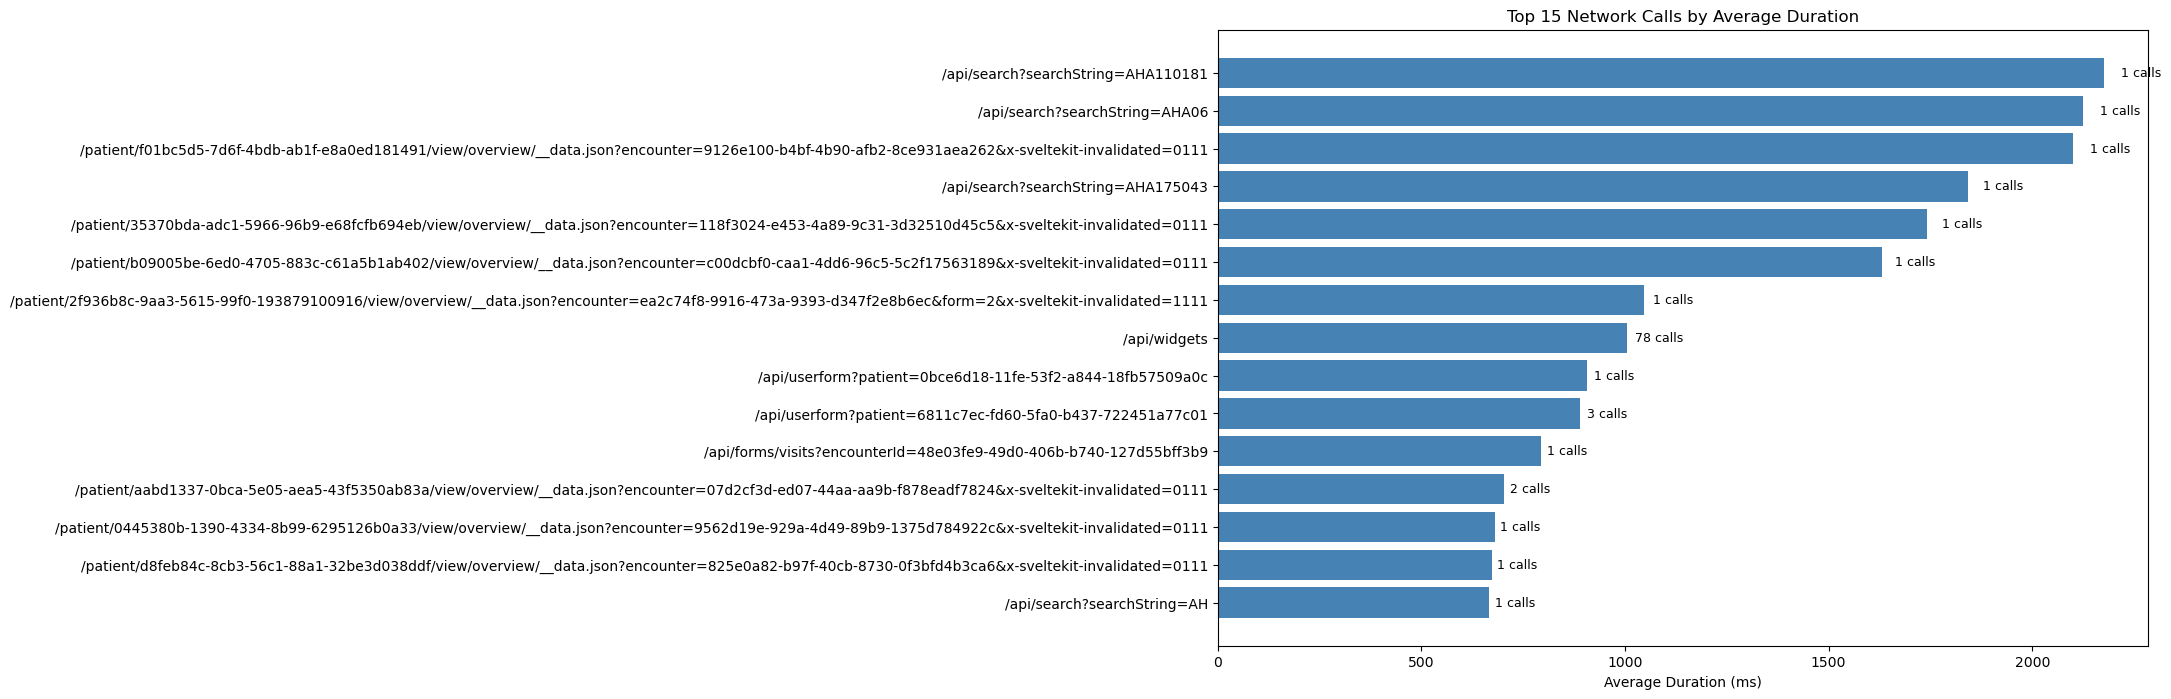

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure all_spans_df is defined with columns:
# ['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms']

# 1. Aggregate span data by URL
agg_by_url = (
    all_spans_df[all_spans_df['url'].notnull()]
    .groupby('url')
    .agg(
        avg_duration=('duration_ms', 'mean'),
        call_count=('duration_ms', 'count'),
        max_duration=('duration_ms', 'max')
    )
    .reset_index()
)

# 2. Sort endpoints by average duration and select the top 15
top15 = agg_by_url.sort_values('avg_duration', ascending=False).head(15)
print("Top 15 Network Calls by Average Duration:")
print(top15)

# 3. Plot a horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(top15['url'], top15['avg_duration'], color='steelblue')
plt.xlabel("Average Duration (ms)")
plt.title("Top 15 Network Calls by Average Duration")
plt.gca().invert_yaxis()  # Highest average duration on top

# 4. Annotate each bar with the call count
for i, bar in enumerate(bars):
    call_count = int(top15.iloc[i]['call_count'])
    plt.text(
        bar.get_width() * 1.02, 
        bar.get_y() + bar.get_height() / 2, 
        f"{call_count} calls", 
        va='center', 
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# 1. Find the trace with the highest total duration
trace_durations = all_spans_df.groupby('trace_id')['duration_ms'].sum().reset_index()
highest_trace_id = trace_durations.sort_values('duration_ms', ascending=False).iloc[0]['trace_id']

print(f"Trace with highest total duration: {highest_trace_id}")

# 2. Extract all spans for this trace
spans_in_highest_trace = all_spans_df[all_spans_df['trace_id'] == highest_trace_id]

# 3. Sort spans by duration in descending order
sorted_spans = spans_in_highest_trace.sort_values('duration_ms', ascending=False)

# 4. Select relevant columns to display
sorted_spans[['span_id', 'service', 'url', 'db_statement', 'duration_ms']]


Trace with highest total duration: 2fe3d566f6712634e94e846847f974b


,span_id,service,url,db_statement,duration_ms
3758,9eAChVwT4rw=,None,/api/widgets,None,5411.486636
3759,sKsy9E5ysvU=,None,/ehrbase/rest/openehr/v1/query/aql,None,5405.928647
3761,a+mTKjbJ4iY=,None,None,None,58.496765
3760,Ie26+ZSLwQc=,None,None,None,6.743951


# need to fix: service name doesnt get imported